<h1> MBA Analysis </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

<h7>2/17/22</h7>

 

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


<h3> Initial BigQuery SQL Speed Queries </h3>
<p>IPv4 with multiple concurrent TCP connections</p>

In [18]:
# ***DOWNLOAD***


# between 19:00 and 23:00...inclusive?
peak_download_sql = """
SELECT 
    mt.Download as download_service_tier,
    mt.ISP as ISP,
    mt.Technology as tech,
    avg(httpmt.bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as lowest_5_percent_Mbps,
    APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as top_95_percent_Mbps,
    MAX(httpmt.bytes_sec/125000) as max_Mbps, 
    MIN(httpmt.bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt.bytes_sec/125000) as STD, 
    COUNT(DISTINCT httpmt.unit_id) as total_boxes
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON httpmt.unit_id=mt.Unit_ID
WHERE (EXTRACT(HOUR FROM httpmt.dtime) between 19 AND 23)
GROUP BY download_service_tier, ISP, tech
ORDER BY download_service_tier, ISP
"""
# ORDER BY STD DESC

fullDay_download_sql = """
SELECT 
    mt.Download as download_service_tier,
    mt.ISP as ISP,
    mt.Technology as tech,
    avg(httpmt.bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as lowest_5_percent_Mbps,
    APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as top_95_percent_Mbps,
    MAX(httpmt.bytes_sec/125000) as max_Mbps, 
    MIN(httpmt.bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt.bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt.unit_id) as total_boxes
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON httpmt.unit_id=mt.Unit_ID
GROUP BY download_service_tier, ISP, tech
ORDER BY download_service_tier, ISP
"""
# ORDER BY STD DESC
# WHERE (EXTRACT(HOUR FROM httpmt.dtime) NOT between 19 AND 23)



# ***UPLOAD***


# between 19:00 and 23:00...inclusive?
peak_upload_sql = """
SELECT
    mt.Upload as upload_service_tier,
    mt.ISP as ISP,
    mt.Technology as tech,
    avg(httppmt.bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httppmt.bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httppmt.bytes_sec/125000, 100)[OFFSET(5)] as lowest_5_percent_Mbps,
    APPROX_QUANTILES(httppmt.bytes_sec/125000, 100)[OFFSET(95)] as top_95_percent_Mbps,
    MAX(httppmt.bytes_sec/125000) as max_Mbps, 
    MIN(httppmt.bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httppmt.bytes_sec/125000) as STD,
    COUNT(DISTINCT httppmt.unit_id) as total_boxes
FROM `broadband-data.mba_data.curr_httppostmt` as httppmt
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON httppmt.unit_id=mt.Unit_ID
WHERE (EXTRACT(HOUR FROM httppmt.dtime) between 19 AND 23)
GROUP BY upload_service_tier, ISP, tech
ORDER BY upload_service_tier, ISP
"""

fullDay_upload_sql = """
SELECT
    mt.Upload as upload_service_tier,
    mt.ISP as ISP,
    mt.Technology as tech,
    avg(httppmt.bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httppmt.bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httppmt.bytes_sec/125000, 100)[OFFSET(5)] as lowest_5_percent_Mbps,
    APPROX_QUANTILES(httppmt.bytes_sec/125000, 100)[OFFSET(95)] as top_95_percent_Mbps,
    MAX(httppmt.bytes_sec/125000) as max_Mbps, 
    MIN(httppmt.bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httppmt.bytes_sec/125000) as STD,
    COUNT(DISTINCT httppmt.unit_id) as total_boxes
FROM `broadband-data.mba_data.curr_httppostmt` as httppmt
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON httppmt.unit_id=mt.Unit_ID
GROUP BY upload_service_tier, ISP, tech
ORDER BY upload_service_tier, ISP
"""
# WHERE (EXTRACT(HOUR FROM httppmt.dtime) NOT between 19 AND 23)


# Creating main dataframes
peak_download = client.query(peak_download_sql).to_dataframe()
fullDay_download = client.query(fullDay_download_sql).to_dataframe()
peak_upload = client.query(peak_upload_sql).to_dataframe()
fullDay_upload = client.query(fullDay_upload_sql).to_dataframe()



<h4>Peak-hour download data</h4>

In [19]:
peak_download

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,lowest_5_percent_Mbps,top_95_percent_Mbps,max_Mbps,min_Mbps,STD,total_boxes
0,0.768,CenturyLink,DSL,0.893276,0.957536,0.311720,1.229032,1.336112,0.101672,0.321686,1
1,1.000,Frontier,DSL,1.310053,1.318560,1.081472,1.480408,1.523976,0.509480,0.150713,3
2,1.000,Verizon DSL,DSL,0.845454,0.922744,0.701224,0.946336,1.049128,0.178944,0.118825,7
3,1.500,CenturyLink,DSL,1.210811,1.235744,0.669256,1.492840,1.934584,0.022072,0.257870,65
4,3.000,CenturyLink,DSL,2.850792,2.832320,1.484872,4.766320,5.404400,0.016840,0.897564,50
5,3.000,Comcast,Cable,3.511462,3.556472,3.279112,3.577728,3.607728,0.262824,0.230169,10
6,3.000,Frontier,DSL,2.425750,2.632312,1.198840,3.585376,3.998760,0.276048,0.724883,24
7,3.000,Verizon DSL,DSL,2.022737,2.307192,0.570384,2.804664,2.846840,0.115192,0.724003,23
8,3.000,Windstream,DSL,2.598924,2.665840,0.547472,3.546224,4.398760,0.020112,0.863872,15
9,4.000,CenturyLink,DSL,2.780004,2.498256,2.170936,3.983688,3.988160,1.754144,0.596730,2


<h4>Full-day Download Data</h4>

In [20]:
fullDay_download

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,lowest_5_percent_Mbps,top_95_percent_Mbps,max_Mbps,min_Mbps,STD,total_boxes
0,0.768,CenturyLink,DSL,0.951923,1.133592,0.354208,1.232376,1.336112,0.065600,0.307096,1
1,1.000,Frontier,DSL,1.276271,1.325272,0.936072,1.483752,1.540984,0.161048,0.211070,3
2,1.000,Verizon DSL,DSL,0.869654,0.926024,0.708472,0.991032,1.080408,0.017896,0.114351,7
3,1.500,CenturyLink,DSL,1.245270,1.249120,0.773144,1.523976,1.964504,0.002232,0.245167,65
4,3.000,CenturyLink,DSL,2.995939,2.870304,1.836816,4.902648,9.895568,0.005592,0.980693,50
5,3.000,Comcast,Cable,3.504590,3.557408,3.187368,3.579376,3.683936,0.262824,0.201568,10
6,3.000,Frontier,DSL,2.541429,2.775128,1.217840,3.619992,4.002112,0.274936,0.747847,24
7,3.000,Verizon DSL,DSL,2.195570,2.411232,0.864504,2.809232,2.869192,0.005584,0.667580,23
8,3.000,Windstream,DSL,2.721502,2.787624,0.566216,4.077464,4.675856,0.020112,0.816491,15
9,4.000,CenturyLink,DSL,3.043655,2.959216,2.266936,3.987048,3.988160,1.431248,0.673693,2


<h4>Peak Upload Data</h4>

In [21]:
peak_upload

,upload_service_tier,ISP,tech,avg_Mbps,median_Mbps,lowest_5_percent_Mbps,top_95_percent_Mbps,max_Mbps,min_Mbps,STD,total_boxes
0,0.128,Frontier,DSL,0.352519,0.353416,0.333280,0.373256,0.380168,0.233744,0.015940,3
1,0.256,CenturyLink,DSL,0.192903,0.203536,0.099544,0.244552,0.471552,0.027848,0.058068,20
2,0.384,Frontier,DSL,0.507050,0.554656,0.149840,0.697880,0.737888,0.135312,0.183899,13
3,0.384,Verizon DSL,DSL,0.303340,0.350672,0.162288,0.367848,0.378080,0.071432,0.078656,7
4,0.500,CenturyLink,DSL,0.489632,0.420512,0.234848,0.795176,0.806360,0.148744,0.175207,6
5,0.512,CenturyLink,DSL,0.268957,0.216960,0.115192,0.530584,0.778400,0.048608,0.145785,51
6,0.512,Frontier,DSL,0.869301,0.762736,0.432816,1.393864,1.423952,0.361240,0.338468,7
7,0.640,CenturyLink,DSL,0.620457,0.632440,0.463008,0.763768,0.839800,0.139792,0.097842,22
8,0.750,CenturyLink,DSL,0.647166,0.675512,0.204672,0.850264,1.014456,0.037072,0.160779,34
9,0.768,CenturyLink,DSL,0.695408,0.696640,0.503280,0.877360,1.058768,0.157696,0.107424,55


<h4>Full-day Upload Data</h4>

In [22]:
fullDay_upload

,upload_service_tier,ISP,tech,avg_Mbps,median_Mbps,lowest_5_percent_Mbps,top_95_percent_Mbps,max_Mbps,min_Mbps,STD,total_boxes
0,0.128,Frontier,DSL,0.343986,0.352296,0.332160,0.364592,0.380168,0.016776,0.043770,3
1,0.256,CenturyLink,DSL,0.190928,0.203528,0.101776,0.248280,0.493216,0.018472,0.055637,20
2,0.384,Frontier,DSL,0.532650,0.571720,0.200184,0.698992,0.737888,0.070448,0.167175,13
3,0.384,Verizon DSL,DSL,0.284919,0.335352,0.162288,0.367848,0.385560,0.071432,0.084022,7
4,0.500,CenturyLink,DSL,0.471749,0.420512,0.269568,0.798528,0.850168,0.090712,0.155614,7
5,0.512,CenturyLink,DSL,0.329353,0.297496,0.119656,0.664696,0.778400,0.031280,0.164379,51
6,0.512,Frontier,DSL,0.833274,0.705256,0.436176,1.396640,1.425056,0.361240,0.301463,7
7,0.640,CenturyLink,DSL,0.635622,0.641952,0.473080,0.785912,0.869752,0.123016,0.095204,22
8,0.750,CenturyLink,DSL,0.669256,0.687808,0.228096,0.904624,1.014456,0.003352,0.161193,35
9,0.768,CenturyLink,DSL,0.681091,0.688928,0.496552,0.855568,1.140792,0.045872,0.105969,56


<h3> Sample Download Speed Data & Graphs w/ Comcast</h3>

In [23]:
# Comcast Dataframes

# Download 
df_peak_download_comcast = peak_download[peak_download['ISP']=="Comcast"]
df_fullDay_download_comcast = fullDay_download[fullDay_download['ISP']=="Comcast"]

# Upload

df_peak_upload_comcast = peak_upload[peak_upload['ISP']=="Comcast"]
df_fullDay_upload_comcast = fullDay_upload[fullDay_upload['ISP']=="Comcast"]


In [11]:
df_peak_download_comcast

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,lowest_5_percent_Mbps,top_95_percent_Mbps,max_Mbps,min_Mbps,STD,sample_size
5,3.0,Comcast,Cable,3.511462,3.556472,3.279112,3.577728,3.607728,0.262824,0.230169,10
30,15.0,Comcast,Cable,16.797835,17.828472,9.627640,17.864512,17.884024,9.386312,2.459733,1
43,25.0,Comcast,Cable,28.419018,29.699632,23.594880,29.793208,30.241992,0.197568,3.709781,57
52,35.0,Comcast,Cable,41.647737,41.646128,41.507840,41.825888,41.935408,41.442992,0.075714,2
65,70.0,Comcast,Cable,81.138179,82.616488,73.697920,83.436712,83.593912,64.365872,3.641850,4
67,75.0,Comcast,Cable,86.883362,88.877400,78.446848,89.412880,89.875416,26.249472,4.915926,42
75,100.0,Comcast,Cable,114.927412,118.729664,93.931080,119.613016,121.017336,0.227976,10.566201,59
82,105.0,Comcast,Cable,112.864438,114.152488,99.201280,119.764312,120.711112,92.254640,5.990908,3
88,175.0,Comcast,Cable,201.187753,207.945368,175.948088,208.656456,208.998904,12.501008,24.287269,40
90,200.0,Comcast,Cable,229.356936,235.659080,200.418256,238.439256,350.955728,0.129736,18.011758,66


In [ ]:
df_fullDay_download_comcast

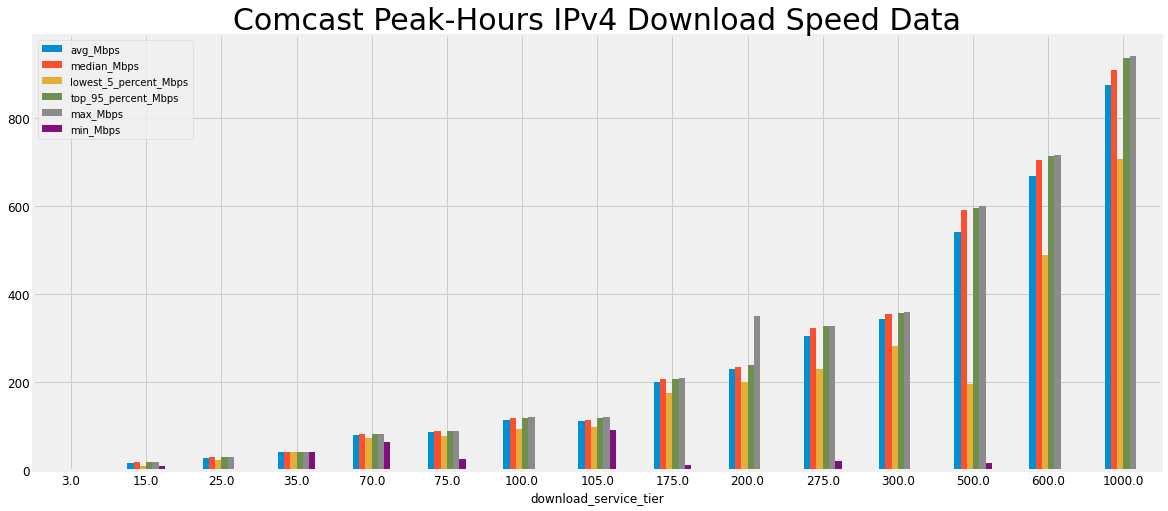

In [65]:
ax = df_peak_comcast.plot.bar(x="download_service_tier", 
                         y = ["avg_Mbps", "median_Mbps", "lowest_5_percent_Mbps", "top_95_percent_Mbps", 
                              "max_Mbps","min_Mbps"], rot=0, figsize=(18,8), fontsize = 12)

ax.set_title('Comcast Peak-Hours IPv4 Download Speed Data',fontsize= 30) 
plt.show()

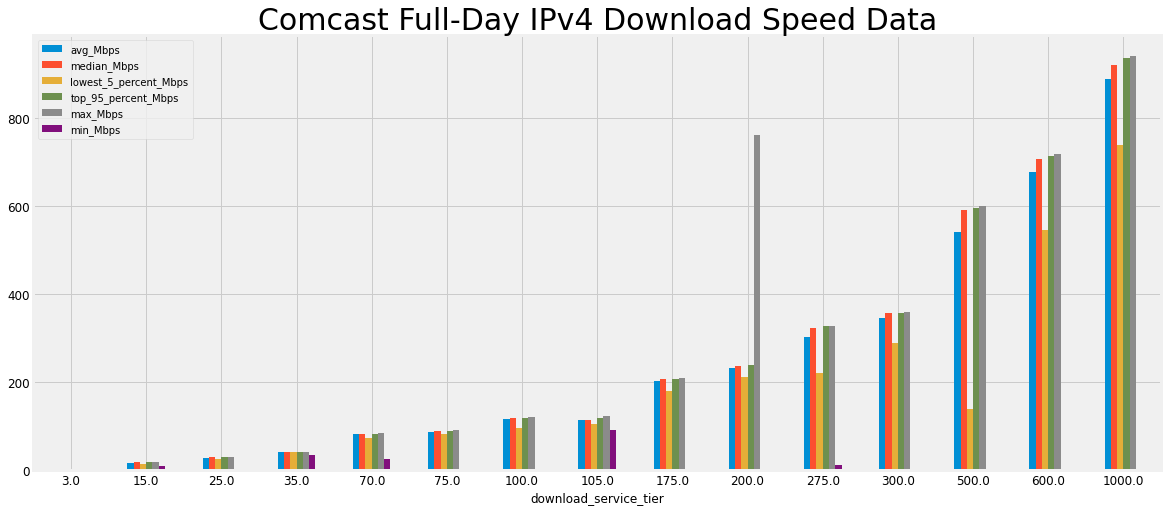

In [64]:
ax = df_fullDay_download_comcast.plot.bar(x="download_service_tier", 
                         y = ["avg_Mbps", "median_Mbps", "lowest_5_percent_Mbps", "top_95_percent_Mbps", 
                              "max_Mbps","min_Mbps"], rot=0, figsize=(18,8), fontsize = 12)

ax.set_title('Comcast Full-Day IPv4 Download Speed Data',fontsize= 30) 
plt.show()

<h3> Sample Upload Speed Data & Graphs w/ Comcast </h3>

In [ ]:
df_peak_upload_comcast

In [ ]:
df_fullDay_upload_comcast

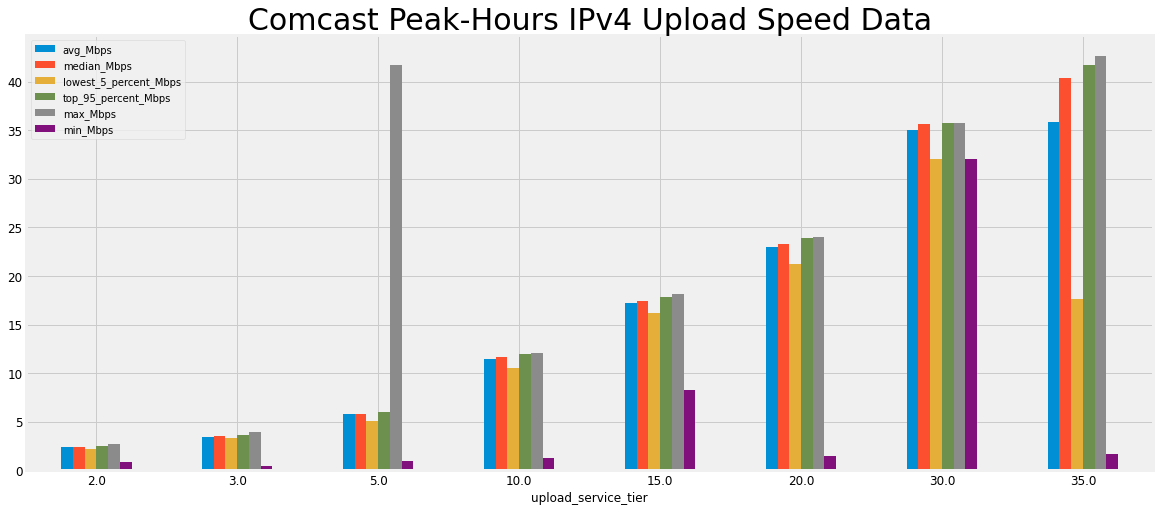

In [73]:
ax = df_peak_upload_comcast.plot.bar(x="upload_service_tier", 
                         y = ["avg_Mbps", "median_Mbps", "lowest_5_percent_Mbps", "top_95_percent_Mbps", 
                              "max_Mbps","min_Mbps"], rot=0, figsize=(18,8), fontsize = 12)

ax.set_title('Comcast Peak-Hours IPv4 Upload Speed Data',fontsize= 30) 
plt.show()

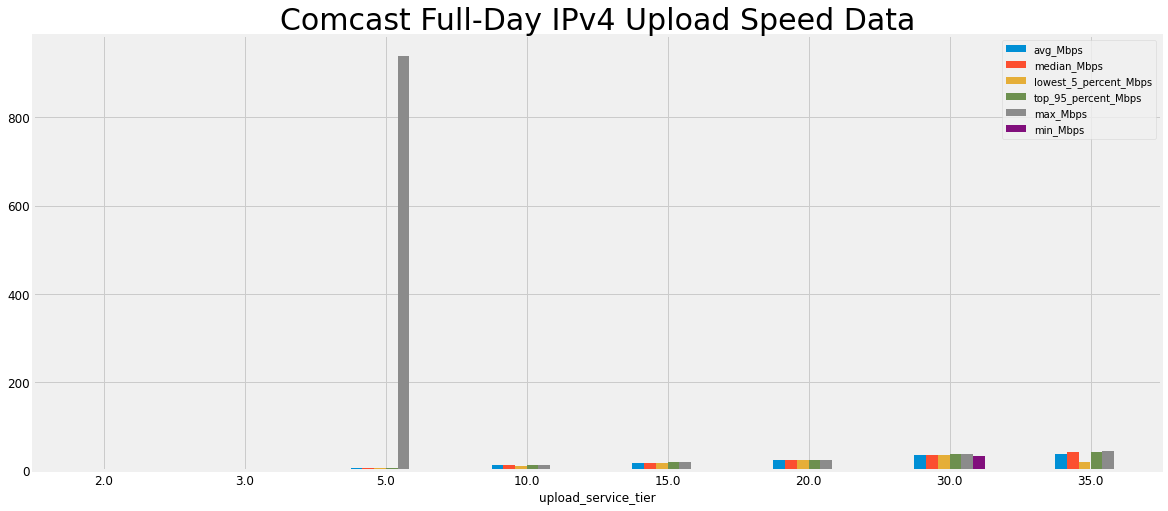

In [72]:
ax = df_fullDay_upload_comcast.plot.bar(x="upload_service_tier", 
                         y = ["avg_Mbps", "median_Mbps", "lowest_5_percent_Mbps", "top_95_percent_Mbps", 
                              "max_Mbps","min_Mbps"], rot=0, figsize=(18,8), fontsize = 12)

ax.set_title('Comcast Full-Day IPv4 Upload Speed Data',fontsize= 30) 
plt.show()

<h3>BigQuery SQL Speed Queries </h3>
<p>IPv4 with single TCP connection</p>

In [81]:
# ***DOWNLOAD***


# between 19:00 and 23:00...inclusive?
s_peak_download_sql = """
SELECT 
    mt.Download as download_service_tier,
    mt.ISP as ISP,
    mt.Technology as tech,
    avg(http.bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(http.bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(http.bytes_sec/125000, 100)[OFFSET(5)] as lowest_5_percent_Mbps,
    APPROX_QUANTILES(http.bytes_sec/125000, 100)[OFFSET(95)] as top_95_percent_Mbps,
    MAX(http.bytes_sec/125000) as max_Mbps, 
    MIN(http.bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(http.bytes_sec/125000) as STD
FROM `broadband-data.mba_data.curr_httpget` as http
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON http.unit_id=mt.Unit_ID
WHERE (EXTRACT(HOUR FROM http.dtime) between 19 AND 23)
GROUP BY download_service_tier, ISP, tech
ORDER BY download_service_tier, ISP
"""
# ORDER BY STD DESC

s_fullDay_download_sql = """
SELECT 
    mt.Download as download_service_tier,
    mt.ISP as ISP,
    mt.Technology as tech,
    avg(http.bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(http.bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(http.bytes_sec/125000, 100)[OFFSET(5)] as lowest_5_percent_Mbps,
    APPROX_QUANTILES(http.bytes_sec/125000, 100)[OFFSET(95)] as top_95_percent_Mbps,
    MAX(http.bytes_sec/125000) as max_Mbps, 
    MIN(http.bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(http.bytes_sec/125000) as STD
FROM `broadband-data.mba_data.curr_httpget` as http
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON http.unit_id=mt.Unit_ID
GROUP BY download_service_tier, ISP, tech
ORDER BY download_service_tier, ISP
"""
# ORDER BY STD DESC
# WHERE (EXTRACT(HOUR FROM http.dtime) NOT between 19 AND 23)



# ***UPLOAD***

# between 19:00 and 23:00...inclusive?
s_peak_upload_sql = """
SELECT
    mt.Upload as upload_service_tier,
    mt.ISP as ISP,
    mt.Technology as tech,
    avg(httpp.bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpp.bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpp.bytes_sec/125000, 100)[OFFSET(5)] as lowest_5_percent_Mbps,
    APPROX_QUANTILES(httpp.bytes_sec/125000, 100)[OFFSET(95)] as top_95_percent_Mbps,
    MAX(httpp.bytes_sec/125000) as max_Mbps, 
    MIN(httpp.bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpp.bytes_sec/125000) as STD
FROM `broadband-data.mba_data.curr_httppost` as httpp
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON httpp.unit_id=mt.Unit_ID
WHERE (EXTRACT(HOUR FROM httpp.dtime) between 19 AND 23)
GROUP BY upload_service_tier, ISP, tech
ORDER BY upload_service_tier, ISP
"""

s_fullDay_upload_sql = """
SELECT
    mt.Upload as upload_service_tier,
    mt.ISP as ISP,
    mt.Technology as tech,
    avg(httpp.bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpp.bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpp.bytes_sec/125000, 100)[OFFSET(5)] as lowest_5_percent_Mbps,
    APPROX_QUANTILES(httpp.bytes_sec/125000, 100)[OFFSET(95)] as top_95_percent_Mbps,
    MAX(httpp.bytes_sec/125000) as max_Mbps, 
    MIN(httpp.bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpp.bytes_sec/125000) as STD
FROM `broadband-data.mba_data.curr_httppost` as httpp
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON httpp.unit_id=mt.Unit_ID
GROUP BY upload_service_tier, ISP, tech
ORDER BY upload_service_tier, ISP
"""
# WHERE (EXTRACT(HOUR FROM httpp.dtime) NOT between 19 AND 23)


# Creating main dataframes
peak_download_s = client.query(s_peak_download_sql).to_dataframe()
fullDay_download_s = client.query(s_fullDay_download_sql).to_dataframe()
peak_upload_s = client.query(s_peak_upload_sql).to_dataframe()
fullDay_upload_s = client.query(s_fullDay_upload_sql).to_dataframe()

In [82]:
peak_download_s

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,lowest_5_percent_Mbps,top_95_percent_Mbps,max_Mbps,min_Mbps,STD
0,0.768,CenturyLink,DSL,1.033113,1.351912,0.147312,1.422448,1.429360,0.001120,0.497758
1,1.500,CenturyLink,DSL,1.130012,1.235936,0.208936,1.470792,1.543296,0.021984,0.388506
2,3.000,Windstream,DSL,2.465978,2.592104,0.425688,3.935912,4.288136,0.031072,1.112697
3,4.000,Windstream,DSL,3.850155,4.350080,1.578728,4.391744,4.587568,0.006904,0.950490
4,6.000,Frontier,DSL,2.592854,1.672192,0.090920,6.435560,6.633512,0.045808,2.253350
5,6.000,Windstream,DSL,6.066483,6.025848,4.990912,6.856776,6.918216,0.474152,0.758038
6,10.000,CenturyLink,DSL,9.034672,9.616464,5.631120,11.685664,12.058632,0.444680,1.793495
7,10.000,Windstream,DSL,6.954690,8.251608,1.145096,10.686808,14.702360,0.237072,2.895802
8,12.000,CenturyLink,DSL,11.984832,12.845416,2.890424,16.499672,16.900040,0.126592,4.077319
9,12.000,Frontier,DSL,11.588467,11.451056,7.990808,15.797312,15.938272,0.700056,2.621004


In [83]:
fullDay_download_s

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,lowest_5_percent_Mbps,top_95_percent_Mbps,max_Mbps,min_Mbps,STD
0,0.768,CenturyLink,DSL,0.980730,1.297008,0.147312,1.422448,1.442016,0.001120,0.500737
1,1.500,CenturyLink,DSL,1.186842,1.349352,0.306128,1.470864,1.549048,0.005584,0.359054
2,3.000,Windstream,DSL,2.696298,2.959688,0.548584,4.271384,4.380872,0.030168,1.089568
3,4.000,Windstream,DSL,3.980261,4.366336,1.894904,4.402096,4.632264,0.006904,0.844705
4,6.000,Frontier,DSL,3.137181,2.865616,0.105024,6.489192,6.633512,0.045808,2.287985
5,6.000,Windstream,DSL,6.007870,5.980976,5.390912,6.845600,6.921576,0.474152,0.664392
6,10.000,CenturyLink,DSL,9.059975,9.643384,5.610408,10.276792,12.058632,0.351800,1.714096
7,10.000,Windstream,DSL,8.310705,8.281504,1.993240,13.572768,14.702360,0.237072,2.931290
8,12.000,CenturyLink,DSL,12.211631,12.804088,3.489384,16.491872,16.900040,0.067040,3.725706
9,12.000,Frontier,DSL,12.266430,11.467792,7.868880,15.866320,15.975344,0.700056,2.714528


In [84]:
peak_upload_s

,upload_service_tier,ISP,tech,avg_Mbps,median_Mbps,lowest_5_percent_Mbps,top_95_percent_Mbps,max_Mbps,min_Mbps,STD
0,0.256,CenturyLink,DSL,0.196146,0.201648,0.110720,0.316504,0.441336,0.042864,0.058117
1,0.512,CenturyLink,DSL,0.229079,0.210824,0.121904,0.474200,0.733816,0.007832,0.104110
2,0.640,CenturyLink,DSL,0.676341,0.693496,0.574856,0.734968,0.740728,0.475312,0.058805
3,0.750,CenturyLink,DSL,0.636428,0.683128,0.215848,0.786232,0.835384,0.054448,0.148359
4,0.768,CenturyLink,DSL,0.824758,0.826488,0.754112,0.948728,0.955672,0.679976,0.049854
5,0.768,Windstream,DSL,0.581078,0.603640,0.248280,0.754912,0.931960,0.102528,0.136794
6,0.896,CenturyLink,DSL,0.711690,0.713528,0.503280,0.899184,0.959144,0.025720,0.111536
7,1.000,CenturyLink,DSL,0.792526,0.727464,0.594424,1.072504,1.132408,0.010424,0.159276
8,1.000,Frontier,DSL,0.934612,0.948400,0.690048,1.514296,1.592056,0.264960,0.247660
9,1.000,Windstream,DSL,0.902774,0.884648,0.760512,1.183264,1.391600,0.033552,0.129497


In [85]:
fullDay_upload_s

,upload_service_tier,ISP,tech,avg_Mbps,median_Mbps,lowest_5_percent_Mbps,top_95_percent_Mbps,max_Mbps,min_Mbps,STD
0,0.256,CenturyLink,DSL,0.195637,0.206192,0.106248,0.232624,0.441336,0.022368,0.054745
1,0.512,CenturyLink,DSL,0.228732,0.211376,0.107728,0.484264,0.734968,0.005792,0.109974
2,0.640,CenturyLink,DSL,0.688648,0.704584,0.579328,0.732664,0.740728,0.475312,0.048014
3,0.750,CenturyLink,DSL,0.623808,0.680832,0.196840,0.783072,0.843304,0.033408,0.163493
4,0.768,CenturyLink,DSL,0.803498,0.824256,0.593096,0.948728,0.957992,0.308128,0.099956
5,0.768,Windstream,DSL,0.591823,0.612872,0.252752,0.761624,0.934264,0.069120,0.130913
6,0.896,CenturyLink,DSL,0.718205,0.716896,0.506632,0.899704,0.960416,0.025720,0.105477
7,1.000,CenturyLink,DSL,0.767916,0.723600,0.611632,1.059112,1.132408,0.010424,0.137732
8,1.000,Frontier,DSL,0.980385,0.952872,0.691168,1.544504,1.594360,0.264960,0.279494
9,1.000,Windstream,DSL,0.910432,0.892480,0.763864,1.161208,1.403120,0.033552,0.127519
